# Mounting GDrive

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/AI/emotions

/content/drive/MyDrive/AI/emotions


# Importing packages and Data

In [3]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

# Understanding Data

In [4]:
# load facial key points data
keyfacial_df = pd.read_csv('Emotion AI Dataset/data.csv')

In [5]:
keyfacial_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [6]:
# Obtain relavant information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [7]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [8]:
keyfacial_df['Image'].shape

(2140,)

In [9]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [10]:
keyfacial_df['right_eye_center_x'].describe()

count    2140.000000
mean       29.640269
std         2.051575
min        18.922611
25%        28.472224
50%        29.655440
75%        30.858673
max        42.495172
Name: right_eye_center_x, dtype: float64

# Visualizing Data

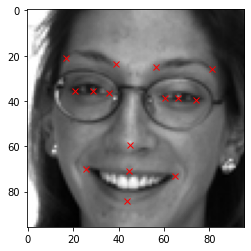

In [11]:
# Plot a random image from the dataset along with facial keypoints. 
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image 
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


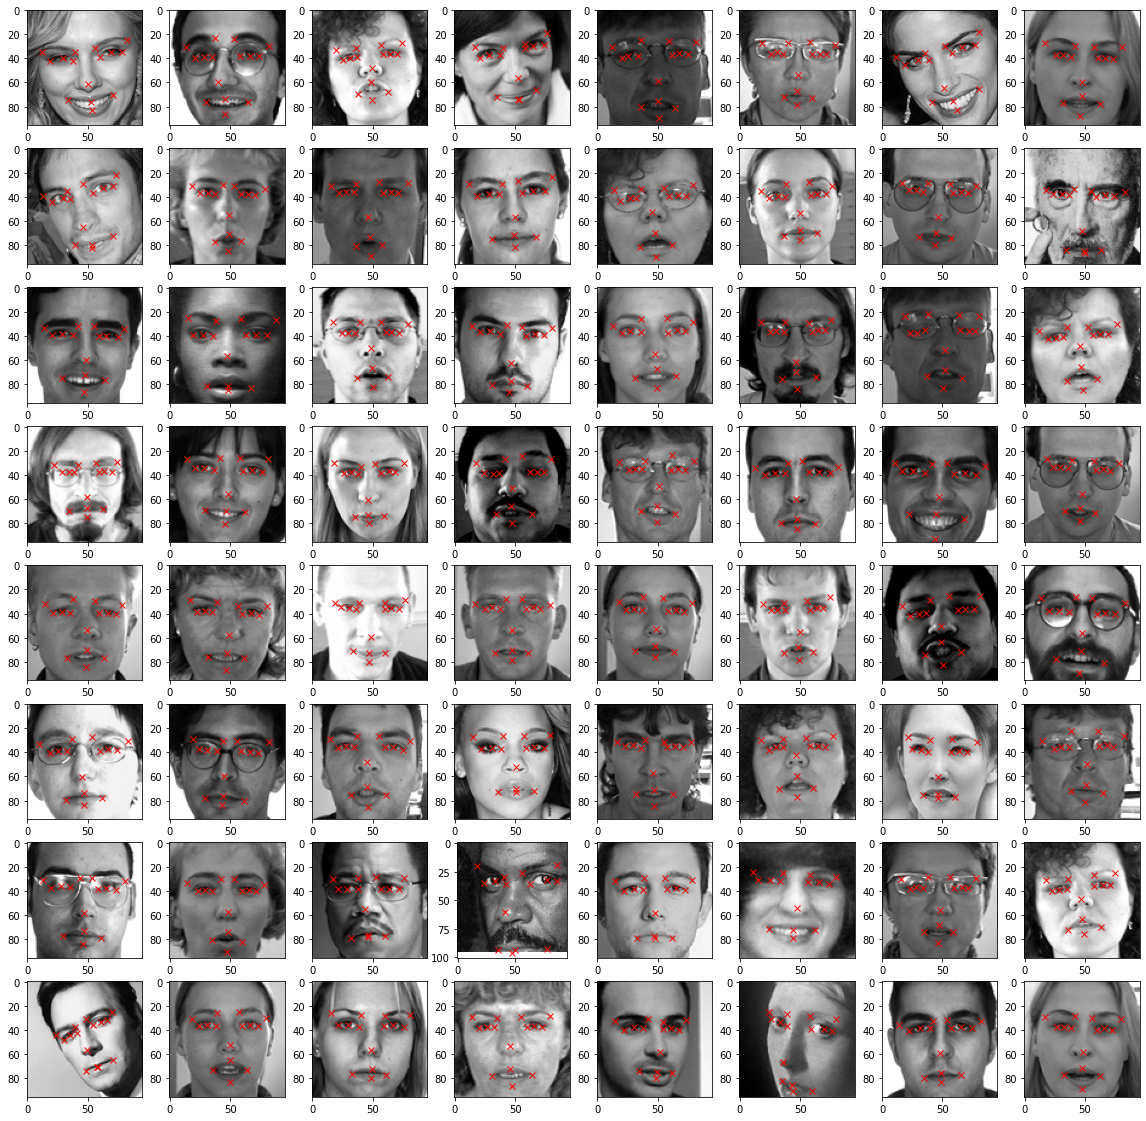

In [12]:
# Let's view 64 random images in a grid format
# This gives us a rough estimate or data validity

fig = plt.figure(figsize=(20, 20))

random_range = np.random.randint(len(keyfacial_df), size=(64))

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][random_range[i]],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[random_range[i]][j-1], keyfacial_df.loc[random_range[i]][j], 'rx')
    

# Image Augmentation

In [13]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [14]:
# Obtain the columns in the dataframe

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

## Horizontal Fliping

In [15]:
# Horizontal Flip - flip the images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

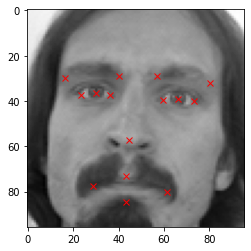

In [16]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

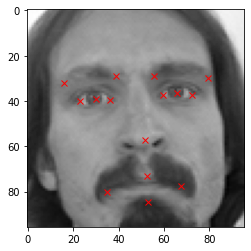

In [17]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [18]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [19]:
augmented_df.shape

(4280, 31)

## Increasing brightness

In [20]:
# Randomingly increasing the brightness of the images
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# we clip the value between 0 and 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

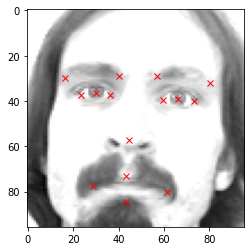

In [21]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

# Perform data normalization and training data preparation


In [22]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [23]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

# Build deep residual neural network key facial points detection model

In [24]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [26]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - stage
X = res_block(X, filter= [256,256,512], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layermodel_1_facialKeyPoints = tf.keras.Model( inputs= X_input, outputs = X)

X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = tf.keras.Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

# Compile and train key facial points detection deep learning model

In [27]:
# adam = optimizers.Nadam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = 'nadam' , metrics = ['accuracy'])

In [28]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [33]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 15, validation_split = 0.025, callbacks=[checkpointer])

Epoch 1/15
157/157 [==============================] - 15s 66ms/step - loss: 38.5902 - accuracy: 0.6403 - val_loss: 57.5826 - val_accuracy: 0.6357

Epoch 00001: val_loss improved from 63.05178 to 57.58259, saving model to FacialKeyPoints_weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
157/157 [==============================] - 10s 65ms/step - loss: 28.9928 - accuracy: 0.6433 - val_loss: 67.7795 - val_accuracy: 0.6357

Epoch 00002: val_loss did not improve from 57.58259
Epoch 3/15
157/157 [==============================] - 10s 65ms/step - loss: 24.6975 - accuracy: 0.6495 - val_loss: 75.0856 - val_accuracy: 0.6279

Epoch 00003: val_loss did not improve from 57.58259
Epoch 4/15
157/157 [==============================] - 10s 65ms/step - loss: 21.2566 - accuracy: 0.6535 - val_loss: 69.2130 - val_accuracy: 0.6357

Epoch 00004: val_loss did not improve from 57.58259
Epoch 5/15
157/157 [==============================] - 10s 65ms/step - loss: 19.4482 - accuracy: 0.6527 - val_loss: 74.8520 - val_accuracy: 0.6279

Epoch 00005: val_loss did not improve from 57.58259
Epoch 6/15
157/157 [==============================] - 10s 66ms/step - loss: 18.3999 - accuracy: 0.6523 - val_loss: 82.1806 - val_accuracy: 0.6202

Epoch 00006: val_loss did not improve from 57.58259
Epoch

In [34]:
# save the model architecture to json file for future use

model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [35]:
with open('FacialKeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

# Assess trained key facial points detection model performance

In [36]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 [==============================] - 2s 23ms/step - loss: 54.0261 - accuracy: 0.6659
Accuracy : 0.6658878326416016


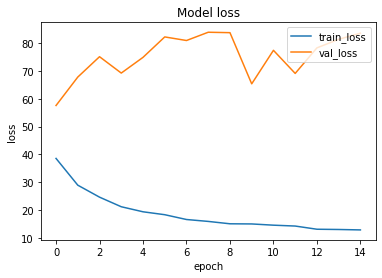

In [37]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# Import & explore dataset for facial expression detection

In [38]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('Emotion AI Dataset/icml_face_data.csv')

In [39]:
facialexpression_df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...,...,...
24563,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564,0,181 177 176 156 178 144 136 132 122 107 131 16...
24565,3,178 174 172 173 181 188 191 194 196 199 200 20...
24566,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...


In [40]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [41]:
# Resize images from (48, 48) to (96, 96)

def resize(x):
  
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [42]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [43]:
facialexpression_df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [44]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

# Visualize data

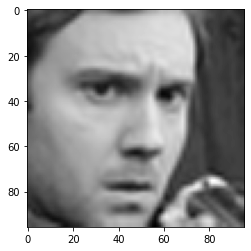

In [45]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

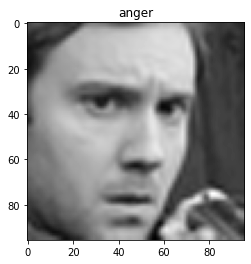

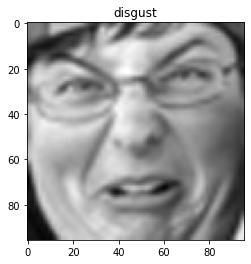

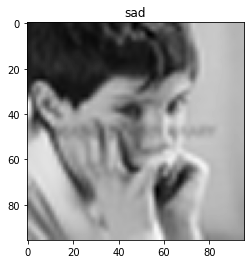

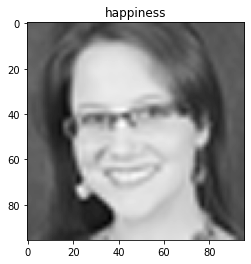

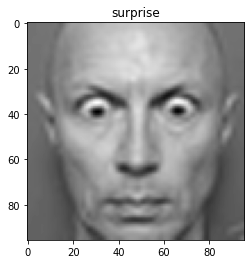

In [46]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [47]:
facialexpression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

# perform data preparation and image augmentation

In [48]:
# split the dataframe in to features and labels
from tensorflow.keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])


In [49]:

X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [50]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [51]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [52]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [53]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [54]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")


# Build and train deep learning model for facial expression classification

In [55]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = tf.keras.Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [56]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [57]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [58]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 10, callbacks=[checkpointer, earlystopping])

Epoch 1/10
345/345 [==============================] - 38s 100ms/step - loss: 1.2320 - accuracy: 0.4983 - val_loss: 1.5089 - val_accuracy: 0.4129

Epoch 00001: val_loss improved from inf to 1.50891, saving model to FacialExpression_weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
345/345 [==============================] - 34s 98ms/step - loss: 0.8889 - accuracy: 0.6523 - val_loss: 1.2003 - val_accuracy: 0.5521

Epoch 00002: val_loss improved from 1.50891 to 1.20028, saving model to FacialExpression_weights.hdf5
Epoch 3/10
345/345 [==============================] - 34s 98ms/step - loss: 0.8007 - accuracy: 0.6894 - val_loss: 1.0171 - val_accuracy: 0.6018

Epoch 00003: val_loss improved from 1.20028 to 1.01708, saving model to FacialExpression_weights.hdf5
Epoch 4/10
345/345 [==============================] - 34s 98ms/step - loss: 0.7498 - accuracy: 0.7085 - val_loss: 0.8499 - val_accuracy: 0.6588

Epoch 00004: val_loss improved from 1.01708 to 0.84988, saving model to FacialExpression_weights.hdf5
Epoch 5/10
345/345 [==============================] - 34s 99ms/step - loss: 0.7099 - accuracy: 0.7292 - val_loss: 0.7736 - val_accuracy: 0.6946

Epoch 00005: val_loss improved from 0.84988 to 0.77356, saving model to FacialExpression_weights.hdf5
Epoch 6/10
3

In [59]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [60]:
with open('FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('FacialExpression_weights.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# Assess the performance of trained facial expression classifier model

In [61]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 2s 23ms/step - loss: 0.8111 - accuracy: 0.6786
Test Accuracy: 0.6786004900932312


In [62]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

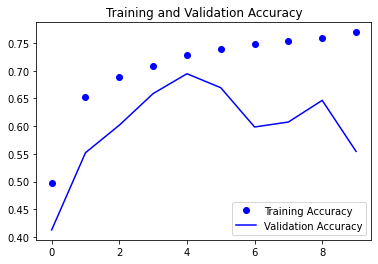

In [63]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

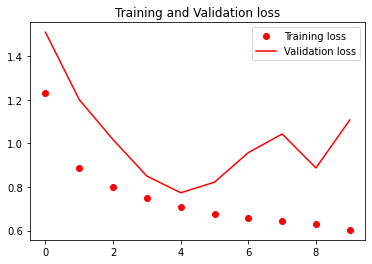

In [64]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [65]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [66]:
y_true.shape

(1229,)

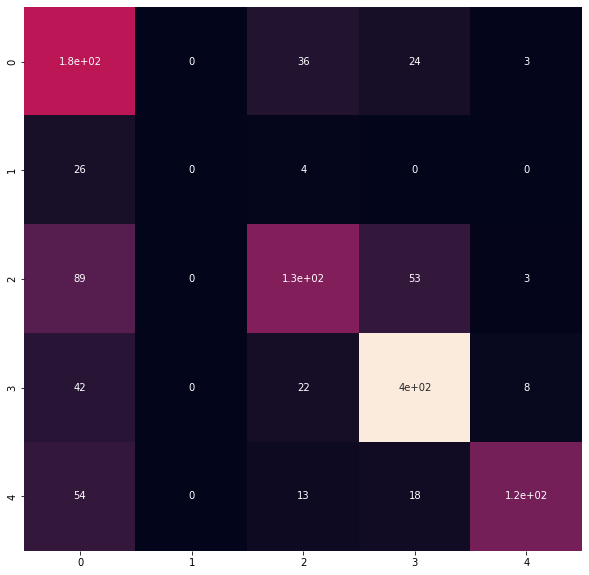

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

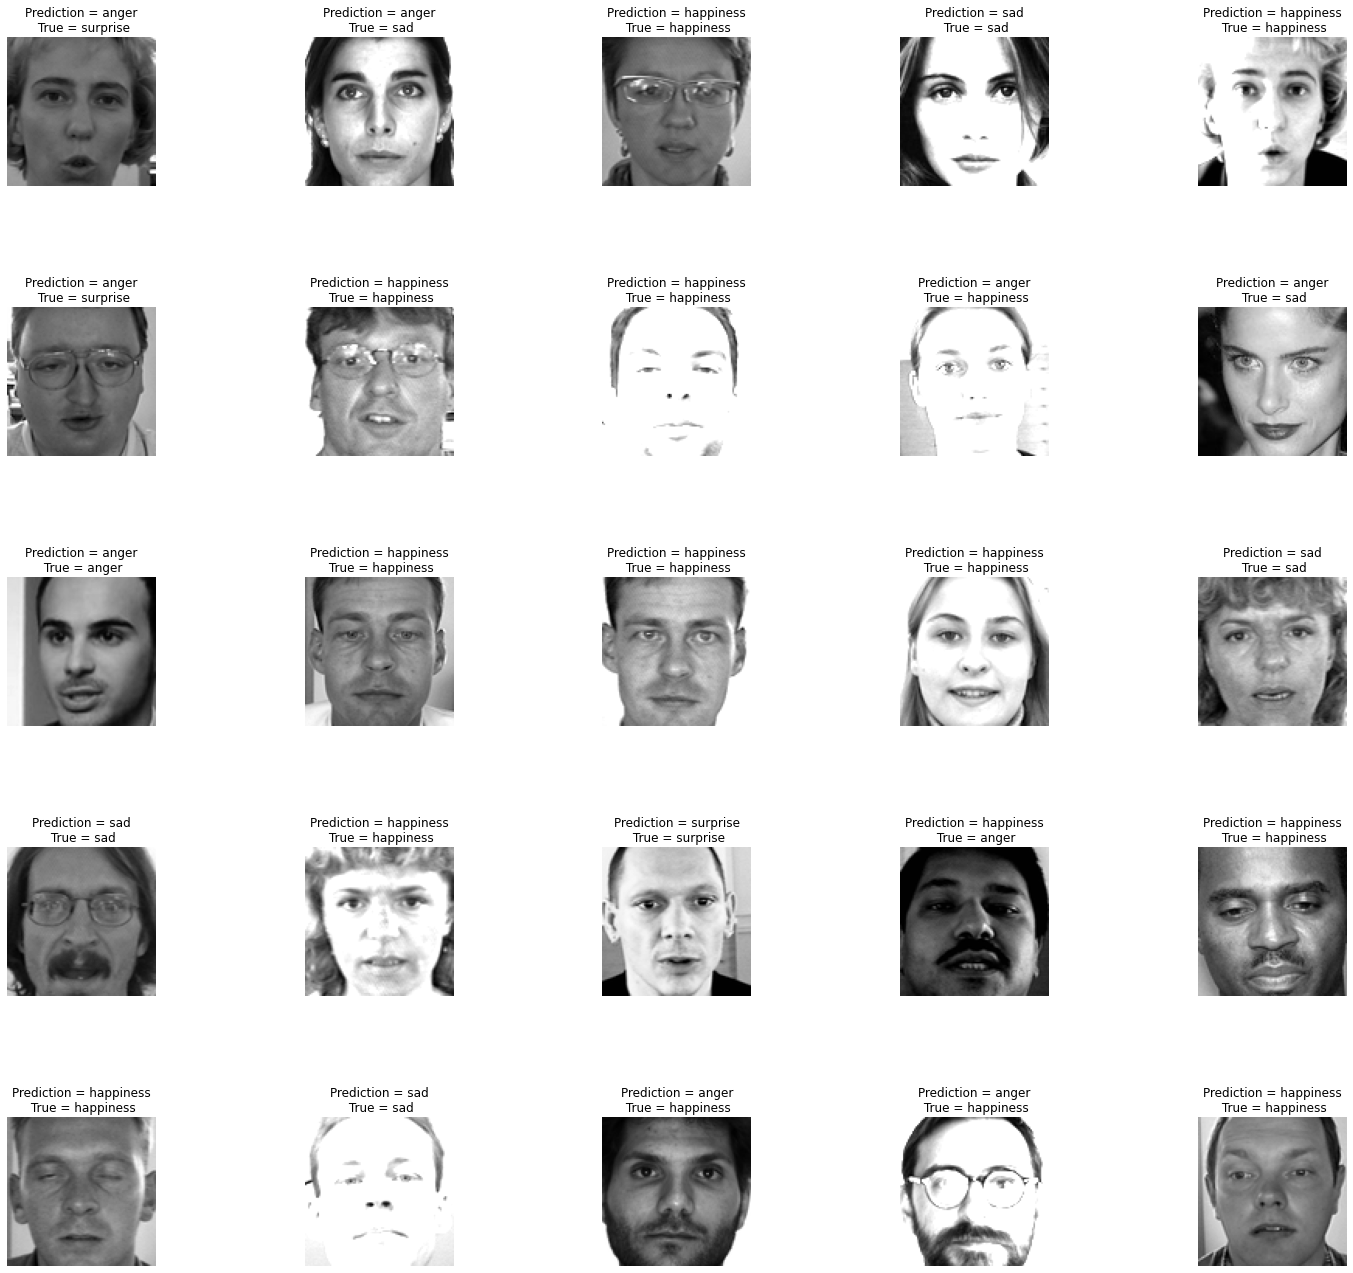

In [68]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.47      0.75      0.57       248
           1       0.00      0.00      0.00        30
           2       0.64      0.48      0.55       277
           3       0.81      0.85      0.83       470
           4       0.89      0.58      0.71       204

    accuracy                           0.68      1229
   macro avg       0.56      0.53      0.53      1229
weighted avg       0.70      0.68      0.67      1229



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Combine both facial expression and key points detection models

In [70]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion
  

  return df_predict

In [73]:
df_predict = predict(X_test)

In [74]:
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,66.014931,37.384022,31.598885,37.932869,60.175316,38.621124,72.141541,38.218395,37.734127,38.922733,24.960884,38.893391,56.907257,29.387217,77.649040,30.099031,40.383121,29.767763,18.905441,31.128790,49.284531,57.482681,63.156452,76.468361,35.154861,76.873886,48.933208,72.709511,49.159729,83.855164,0
1,66.027382,36.000477,28.109066,36.763000,59.001492,37.279922,73.330307,36.830715,35.734333,37.833965,20.344624,37.687668,55.449226,28.306292,79.643715,29.245235,38.711994,28.713327,13.994777,30.800112,47.528099,55.889759,63.166771,74.447403,31.759848,74.803436,47.339394,70.776497,47.474754,81.747093,0
2,66.321709,36.745052,29.082283,36.906372,60.316547,37.699333,72.967430,37.783047,35.902824,37.647221,22.248735,37.772594,56.830448,28.341633,79.254951,29.715273,38.867172,28.565825,15.794661,30.603168,48.240944,55.324749,62.438583,74.842422,33.071182,74.986633,47.728683,69.647614,47.930412,83.354103,0
3,64.751762,36.139172,30.021740,37.242638,57.989368,37.696716,71.713516,36.988789,37.061543,38.523720,22.487568,38.168976,54.744381,28.823408,77.391624,29.279016,39.616222,29.445982,16.801273,30.969501,47.912788,56.738613,62.901665,74.786102,33.125950,75.345757,47.739319,72.290710,47.934608,80.764381,3
4,64.423973,36.176823,30.536755,37.178524,58.134914,37.633507,70.856079,37.008533,37.031303,38.240765,23.488625,38.073326,54.943214,28.769506,76.331696,29.244551,39.486134,29.319921,17.811035,30.681194,47.994743,56.410183,62.256683,74.553024,33.807091,75.016586,47.755657,71.721573,47.970631,80.776299,4


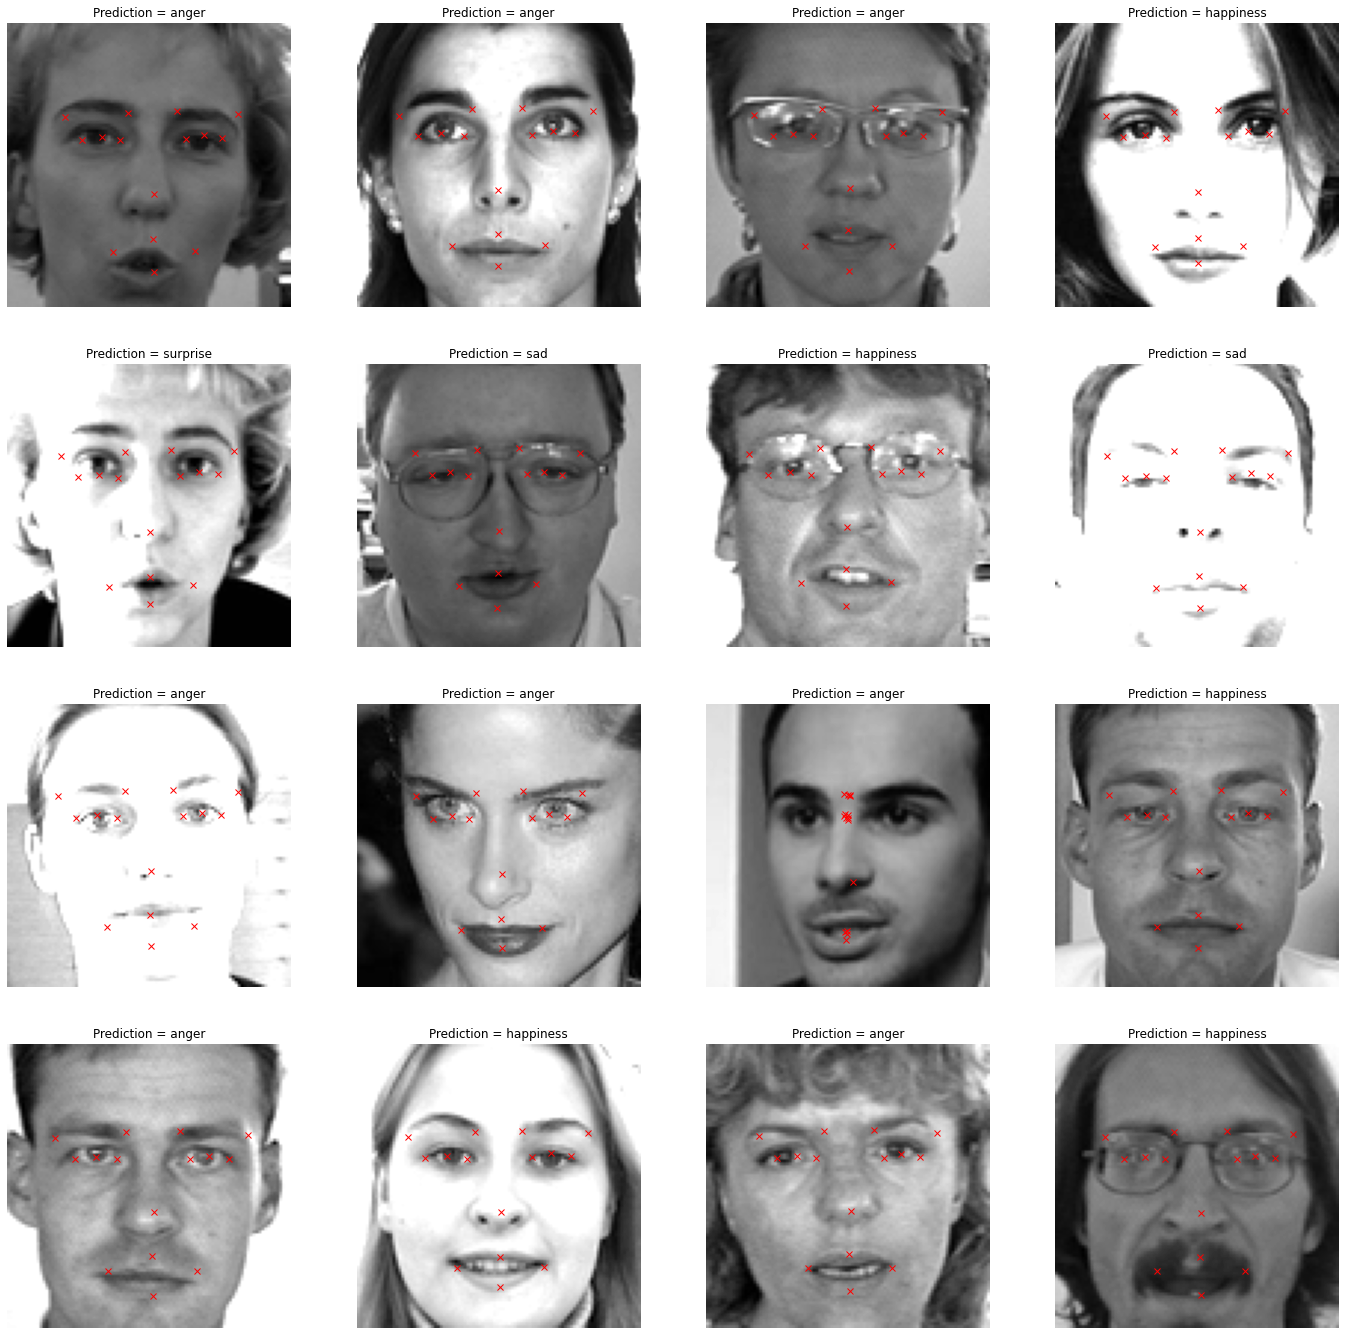

In [75]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            

# Save the trained model for deployment

In [76]:
import json
import tensorflow.keras.backend as K

def deploy(directory, model):
  MODEL_DIR = directory
  version = 1 

  # Let's join the temp model directory with our chosen version number 
  # The expected result will be = '\tmp\version number'
  export_path = os.path.join(MODEL_DIR, str(version))
  print('export_path = {}\n'.format(export_path))

  # Let's save the model using saved_model.save
  # If the directory already exists, we will remove it using '!rm' 
  # rm removes each file specified on the command line. 

  if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

  tf.saved_model.save(model, export_path)

  os.environ["MODEL_DIR"] = MODEL_DIR

## Serve the model using tensorflow serving

In [77]:
# Let's add tensorflow-model-server package to our list of packages 
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  41450      0 --:--:-- --:--:-- --:--:-- 41450
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hi

In [78]:
# Let's install tensorflow model server
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 347 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.6.0 [347 MB]
Fetched 347 MB in 5s (69.3 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.6.0_all.deb ...
Unpacking tensorflow-model-server (2.6.0) ...
Setting up tensorflow-model-server (2.6.0) ...


In [79]:
deploy('/model', model_1_facialKeyPoints)

export_path = /model/1

INFO:tensorflow:Assets written to: /model/1/assets


In [80]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4500 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [81]:
!tail server.log

In [82]:
deploy('/model1', model_2_emotion)

export_path = /model1/1

INFO:tensorflow:Assets written to: /model1/1/assets


In [83]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [84]:
!tail server.log

2021-10-07 05:43:22.969820: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2021-10-07 05:43:22.969987: I tensorflow_serving/model_servers/server_core.cc:591]  (Re-)adding model: emotion_model
2021-10-07 05:43:22.974938: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: emotion_model version: 1}
2021-10-07 05:43:22.975129: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: emotion_model version: 1}
2021-10-07 05:43:22.975255: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: emotion_model version: 1}
2021-10-07 05:43:22.975422: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /model1/1
2021-10-07 05:43:23.019169: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-10-07 05:43:23.020323: I external/org_tensorflow/tensorflow/cc/saved_mod

# Make requests to model in tensorflow serving

In [85]:
import json

# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 198], [0.7372549176216125], [0.7215686440467834]]]]}


In [86]:
!pip install -q requests

In [87]:
import requests

# Function to make predictions from deployed models
def response(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post('http://localhost:4500/v1/models/keypoint_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_predict = json.loads(json_response.text)['predictions']
  json_response = requests.post('http://localhost:4000/v1/models/emotion_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)
  
  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict= pd.DataFrame(df_predict, columns = columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [88]:
# making prediction
df_predict = response(data)

In [89]:
df_predict

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,66.014923,37.384018,31.598886,37.932865,60.175316,38.621117,72.141533,38.218391,37.734123,38.922710,24.960886,38.893394,56.907253,29.387217,77.649025,30.099033,40.383122,29.767757,18.905445,31.128784,49.284531,57.482670,63.156456,76.468353,35.154865,76.873863,48.933205,72.709511,49.159744,83.855179,0
1,66.027389,36.000477,28.109074,36.763004,59.001488,37.279922,73.330322,36.830715,35.734318,37.833965,20.344622,37.687668,55.449238,28.306290,79.643753,29.245232,38.711998,28.713329,13.994778,30.800106,47.528095,55.889755,63.166779,74.447395,31.759853,74.803459,47.339386,70.776489,47.474758,81.747093,0
2,66.321709,36.745060,29.082287,36.906376,60.316544,37.699337,72.967407,37.783051,35.902813,37.647228,22.248735,37.772587,56.830448,28.341633,79.254944,29.715279,38.867168,28.565826,15.794665,30.603170,48.240936,55.324741,62.438580,74.842422,33.071182,74.986610,47.728684,69.647606,47.930420,83.354095,0


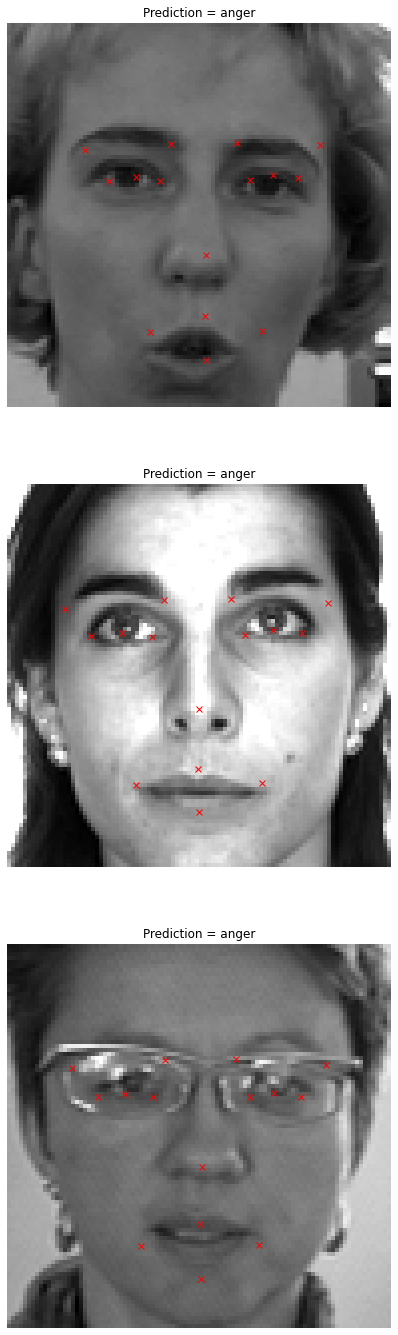

In [90]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(3, 1, figsize = (24, 24))
axes = axes.ravel()

for i in range(3):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            